#### China Scrappage Program Notebook
Author: Aaron Yu  
Last Modified June 27, 2019

# Table of Contents
1. [Objective/Research Question](#Objective/Research-Question)
1. [Setup](#Setup)
    1. [Packages](#Packages)
    1. [Input Data](#Input-Data)

# Objective/Research Question
In recent years, China has worked to reduce air pollution from motor vehicles by progressively tightening its emissions standards for new vehicles. In lieu of a study conducted in 2011 by China's Ministry of Environmental Protection (MEP) which showed that despite the fact that what are known as yellow-label vehicles, vehicles with yellow environmental labels to their windshields, only account for 16% of China's fleet, they account for 87% of the Particulate Matter (PM) emmited from all vehicles nationwide, China has also implemented an ambitious large-scale vehicle scrappage program to accelerate the retirement of older vehicles. We are refining our emission inventory model inputs for China to more accurately reflect the emissions and fleet impacts of China's scrappage program. In this workbook, we estimate the shape of the survival curves that best represent actual historical vehicle retirement patterns in China over the past decade. We estimate specific survival curves by vehicle type and vehicle emission standard.

# Setup
To find incomplete tasks, search for [todo].  
Read in new sales data without rounding error

## Packages


In [1]:
# Load standard packages
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.widgets import Slider, Button, RadioButtons

# Load custom packages
'''
from common.common import *
from common import emissions_calc
'''

# Settings
pd.options.mode.chained_assignment = None

## Input Data
We are using three sets of data to estimate our survival curves for each vehicle type and emmission standard in China. The first data set is a breakdown of China's fleet in 2016 by vehicle type, size, fuel and emmision standard. The second data set is a table of new vehicle sales by vehicle type and years, from 1985-2017. The third dataset is an implementation timeline for China's new vehicle standards, from China 0 (Uncontrolled) to China 6.

**China vehicle stock in 2016 by vehicle type, fuel type, and emissions standard**

In [2]:
targetStock = pd.read_excel("inputs/China-stock-by-vehicle-and-standard-2016.xls")
keep = ['Vehicle','Fuel', 'China 0', 'China 1', 'China 2', 'China 3', 'China 4', 'China 5']
targetStock = targetStock.loc[:,keep]
targetStock = pd.melt(targetStock, id_vars = ['Vehicle','Fuel'], var_name = 'Standard', value_name = 'Stock')
targetStock = targetStock.groupby(by = ['Vehicle', 'Standard','Fuel'])['Stock'].sum().reset_index()
targetStock.head()

,Vehicle,Standard,Fuel,Stock
0,Bus,China 0,diesel,5222.333333
1,Bus,China 0,gasoline,48494.500000
2,Bus,China 0,others,53.666667
3,Bus,China 1,diesel,17996.333333
4,Bus,China 1,gasoline,39225.166667


**China new vehicle sales from 1985 to 2017 by vehicle type and fuel type**

In [3]:
salesData = pd.read_excel("inputs/China-new-vehicle-sales.xlsx",skiprows=1)
#Sales Data is measured in units of 1000s
salesData['NewSales'] = salesData['NewSales']*1000 #Converts sales data from thousands to units
# This analysis focuses on Diesel and Gasoline vehicles
salesData = salesData.loc[salesData.Fuel.isin(['Diesel', 'Gasoline'])]
#TODO: Use dictionary and create a new variable to convert Vehicle type to VehCat in NewStd Timeline
vtypeTovcat = {"Bus":"HDV","HDT":"HDV","LCV":"LDV","PC":"LDV","MDT":"HDV", "MC":"MC"}
salesData['VehCat'] = salesData['Vehicle']
salesData['VehCat'].replace(vtypeTovcat,inplace=True)
salesData.head()

,Vehicle,Fuel,Year,NewSales,VehCat
0,Bus,Diesel,1985,2618.515640,HDV
1,Bus,Diesel,1986,20063.988973,HDV
2,Bus,Diesel,1987,29194.133420,HDV
3,Bus,Diesel,1988,24613.156271,HDV
4,Bus,Diesel,1989,41558.347660,HDV


**China Scrappage Program Data from 2009-2010**

In [4]:
scrappageData = pd.read_excel("inputs/2009-2010 China Scrappage.xlsx")
scrappageData.head()

,Fuel,Standard,Effected
0,Gasoline,China 0,True
1,Diesel,China 0,True
2,Diesel,China 1,True
3,Diesel,China 2,True


## Preliminary analysis of input data
Let's look at China's in-use fleet in 2016 by vehicle type and emission standard. Let's start with HDT.  
- In 2016, there were approximately 5.6 million HDTs in circulation in China.
- 94.6% of HDTs were diesel vehicles certified to China 3 or China 4 standards.
- China 2 diesel vehicles made up 4.3% of the HDT stock.
- China 0 and China 1 HDTs made up less than 1% of the HDT stock.
- Gasoline vehicles made up less than 0.5% of the HDT stock.

In [5]:
hdtData = targetStock.loc[targetStock["Vehicle"] == "HDT"]
hdtData.reset_index(inplace=True,drop=True)
hdtData

#Graphic
#hdtData = hdtData.set_index('Standard')["Stock"].to_dict()
#labels = hdtData.keys()
#sizes = hdtData.values()
#plt.close()
#plt.pie(sizes, labels = labels,autopct='%1.1f%%', shadow=True,pctdistance=1.2,labeldistance=1.35)
#plt.axis('equal')
#plt.show()

,Vehicle,Standard,Fuel,Stock
0,HDT,China 0,diesel,8.993333e+02
1,HDT,China 0,gasoline,1.505000e+02
2,HDT,China 1,diesel,4.364567e+04
3,HDT,China 1,gasoline,2.741667e+02
4,HDT,China 2,diesel,2.417500e+05
5,HDT,China 2,gasoline,8.777333e+03
6,HDT,China 3,diesel,3.225518e+06
7,HDT,China 3,gasoline,4.829500e+03
8,HDT,China 4,diesel,2.099366e+06
9,HDT,China 4,gasoline,5.705000e+02


Let's look at China's new vehicle sales of over time by vehicle type, starting with HDTs.
- Rapid increase in HDT sales from 2006-2010; let's check another data source to verify this (ask Zhenying)
- HDT sales from 1985-2006 averaged roughly 150,000 units per year
- HDT sales from 2010-2017 average roughly 600,000 units per year (equivalent to 10.7% of the HDT stock in 2016)

In [6]:
hdtSales = salesData.loc[salesData.Vehicle=='HDT'].groupby(by = ['Vehicle', 'Year'])['NewSales'].sum().reset_index()
fig, ax = plt.subplots()
ax.plot(hdtSales.Year, hdtSales.NewSales)
ax.set(xlabel='Calendar year', ylabel='Vehicle sales', title='China new vehicle sales of HDTs from 1985-2017')
plt.show()

<IPython.core.display.Javascript object>

# Timeline of Emission Standards
In this section we are reading in data regarding when various emission standards where implemented (China 0-5). This data will later be melted with the sales data to make it easier to check survival curve accuracy.

In [7]:
standardsData = pd.read_excel("inputs/Model-inputs-global-2019.xlsx",sheet_name="NewStd",usecols="A:F")
standardsData = standardsData.loc[(standardsData.ISO=='CHN') & (standardsData.Scenario=='Baseline')]
standardsData.rename(columns={"MY":"Year"},inplace=True)
standardsData.head()x


,ISO,Fuel,VehCat,Year,NewVehCtrl,Scenario
208,CHN,Diesel,HDV,1970,China 0,Baseline
209,CHN,Diesel,HDV,2001,China 1,Baseline
210,CHN,Diesel,HDV,2004,China 2,Baseline
211,CHN,Diesel,HDV,2008,China 3,Baseline
212,CHN,Diesel,HDV,2013,China 4,Baseline


# Calculations
In this section we are created a table of melted data using salesData, standardsData, and scrappageData in order to attach the corresponding standard for each set of vehicles sold in a given year and check whether the stock is effected by the scrappage program.

In [8]:
mergedSalesData = pd.merge(salesData, standardsData, how="left", on=["VehCat","Fuel", "Year"])
mergedSalesData.sort_index(inplace=True)
#todo Group by vehicle type and fuel type and use transform to ensure ffill doesn't spill into next group
mergedSalesData["ISO"].fillna("CHN",inplace=True)
groupvars = ['Vehicle', 'Fuel']
mergedSalesData["Scenario"].fillna("Baseline",inplace=True)
mergedSalesData["NewVehCtrl"] = mergedSalesData.groupby(groupvars)["NewVehCtrl"].transform(lambda x: x.fillna(method="ffill"))
mergedSalesData["NewVehCtrl"].fillna("China 0",inplace=True)
mergedSalesData.rename(index=str, columns={"NewVehCtrl":"Standard"},inplace=True)
mergedSalesData = pd.merge(mergedSalesData, scrappageData, how = "left", on = ["Fuel", "Standard"])
mergedSalesData["Effected"].fillna("False",inplace=True)
mergedSalesData

,Vehicle,Fuel,Year,NewSales,VehCat,ISO,Standard,Scenario,Effected
0,Bus,Diesel,1985,2.618516e+03,HDV,CHN,China 0,Baseline,True
1,Bus,Diesel,1986,2.006399e+04,HDV,CHN,China 0,Baseline,True
2,Bus,Diesel,1987,2.919413e+04,HDV,CHN,China 0,Baseline,True
3,Bus,Diesel,1988,2.461316e+04,HDV,CHN,China 0,Baseline,True
4,Bus,Diesel,1989,4.155835e+04,HDV,CHN,China 0,Baseline,True
5,Bus,Diesel,1990,3.987047e+04,HDV,CHN,China 0,Baseline,True
6,Bus,Diesel,1991,4.885140e+04,HDV,CHN,China 0,Baseline,True
7,Bus,Diesel,1992,8.485064e+04,HDV,CHN,China 0,Baseline,True
8,Bus,Diesel,1993,6.439338e+04,HDV,CHN,China 0,Baseline,True
9,Bus,Diesel,1994,5.326021e+04,HDV,CHN,China 0,Baseline,True


# Survival Curve
We define survival curves using the following functional form:  
$$SR_{i,m} = exp(-(\frac{t}{T_{i,m}})^{k_{i,m}})$$  
This essentially tells us what percent of vehicles should be surviving at a given based on two variables, $T_m$ and $K_m$.

In [9]:
def survcurve(t, Tm = 15.505, Km = 4):
    
    '''Generate a point on a survival curve.
    
    Parameters
    ----------
    t : int (required)
        vehicle age in years.
    Tm : int (optional)
        approximation of the average vehicle retirement age
    Km : int (optional)
        characteristic parameter that defines the steepness of the curve
        
    Returns
    _______
    float : percent of vehicles surviving at age t
    '''
    return round(np.exp(-(t/Tm)**Km),4)

# China 4 Gasoline Passenger Cars

## Extracting the Corresponding Data
In this section we write a function called extractData that extracts data fron the mergedSalesData table given a vehicle type, fuel type, and standard.



In [10]:
def extractData(vehicle, standard,fuel):
    data = mergedSalesData.loc[mergedSalesData["Vehicle"]==vehicle]
    data = data.loc[data["Standard"] == standard]
    data = data.loc[data["Fuel"]==fuel]
    return data

## Calibrating Survival Curve
In this section we are calibrating our survival curve to test its accuracy for China 4 Gasoline Passenger Cars. Since our targetStock data ends in 2016, the age of the vehicle will be determined by $2016 - $its sales year.

In [11]:
#generic survival curve, 
def survcurve(t, Tm = 8, Km = 26.40):
    '''Generate a point on a survival curve.
    
    Parameters
    ----------
    t : int (required)
        vehicle age in years.
    Tm : int (optional)
        approximation of the average vehicle retirement age
    Km : int (optional)
        characteristic parameter that defines the steepness of the curve
        
    Returns
    _______
    float : percent of vehicles surviving at age t
    '''
    return round(np.exp(-(t/Tm)**Km),4)

## Extracting China 4 Gasoline PC Data
In this section we just use our extractData function to extract the correct data from mergedSalesData

In [12]:
salesDataSurvivalCurve = extractData("PC","China 4", "Gasoline")
salesDataSurvivalCurve.head()

,Vehicle,Fuel,Year,NewSales,VehCat,ISO,Standard,Scenario,Effected
349,PC,Gasoline,2011,1.130850e+07,LDV,CHN,China 4,Baseline,False
350,PC,Gasoline,2012,1.534217e+07,LDV,CHN,China 4,Baseline,False
351,PC,Gasoline,2013,1.776536e+07,LDV,CHN,China 4,Baseline,False
352,PC,Gasoline,2014,1.980440e+07,LDV,CHN,China 4,Baseline,False
353,PC,Gasoline,2015,2.101180e+07,LDV,CHN,China 4,Baseline,False


## Applying the Survival Curve
In this section we apply the survival curve to our salesDataSurvivalCurve data by attaching a column called Age that gives the vehicle age and Percent Survivng that contains the percent of vehicles that should be survivng in a given year based on its age. Finally we create a column called Surviving Vehicles, which is the number of cars surviving for a given year, calculated from Percent Surviving x NewSales.

In [13]:
salesDataSurvivalCurve = extractData(vehicle,standard, fuel)
salesDataSurvivalCurve["Age"] = salesDataSurvivalCurve["Year"].apply(lambda x: 2016-x)
salesDataSurvivalCurve["Percent Surviving"] = salesDataSurvivalCurve.apply(lambda x: survcurve(x["Age"],Tm=Tmval,Km=Kmval),axis=1)
salesDataSurvivalCurve["Surviving Vehicles"] = salesDataSurvivalCurve["NewSales"] * salesDataSurvivalCurve["Percent Surviving"]
salesDataSurvivalCurve.reset_index(inplace=True,drop =True)
salesDataSurvivalCurve.head()

NameError: name 'vehicle' is not defined

## Data Comparison
In this section we do a quick comparison from the targetStock to the salesDataSurvivalCurve. We get the total surviving cars by summing up the SurvivingVehicles column in salesDataSurvivalCurve. We can also easily extract the needed data from targetStock.

In [ ]:
def targetStockExtract(vehicle,standard,fuel):
    return targetStock.loc[(targetStock["Vehicle"] == vehicle) &(targetStock["Standard"] == standard) &(targetStock["Fuel"]==fuel.lower())]["Stock"].values[0]

In [ ]:
targetStockData = targetStockExtract("PC","China 4","Gasoline")
print("Target Stock Result: " + str(targetStockData))
estStock = salesDataSurvivalCurve["Surviving Vehicles"].sum()
print("Estimated Stock: " + str(estStock))

In [ ]:
def returnAccuracy(vehicle,standard,fuel,salesDataSurvivalCurve):
    targetStockData = targetStockExtract("PC","China 4","Gasoline")
    estStock = salesDataSurvivalCurve["Surviving Vehicles"].sum()
    return "\n".join(["Target: " +str(int(targetStockData)),"Estimate: "+str(int(estStock)),"Percent Error: " + str(100*((estStock-targetStockData)/targetStockData))])

# Integrated Survival Curve Plot
This section is an interactive plot of the survival curve with sliders for $T_m$ and $K_m$.

<IPython.core.display.Javascript object>


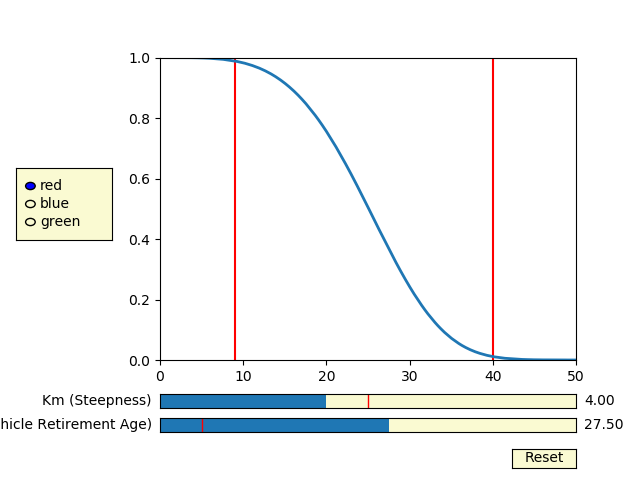

In [16]:
def survivalCurveDisplay(vehicle,fuel,standard):
    scrappage = False
    #Checks whether the scrappage program hits the vehicle set
    info = extractData(vehicle,standard,fuel)
    if info.iloc[0]["Effected"] == True:
        scrappage = False
    
    fig, ax = plt.subplots()
    plt.subplots_adjust(left=0.25, bottom=0.25)
    t = [i/20 for i in range(1000)]
    s = [survcurve(i) for i in t]
    plt.axvline(x=9,color='red')
    plt.axvline(x=40,color='red')
    l, = plt.plot(t, s, lw=2)
    plt.axis([0, 50, 0, 1])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    def colorfunc(label):
        l.set_color(label)
        fig.canvas.draw_idle()
    def reset(event):
        Tm.reset()
        Km.reset()

    def update(val):
        Tmval = Tm.val
        Kmval = Km.val
        l.set_ydata([survcurve(i,Tmval,Kmval) for i in t])
        salesDataSurvivalCurve = extractData(vehicle,standard, fuel)
        salesDataSurvivalCurve["Age"] = salesDataSurvivalCurve["Year"].apply(lambda x: 2016-x)
        salesDataSurvivalCurve["Percent Surviving"] = salesDataSurvivalCurve.apply(lambda x: survcurve(x["Age"],Tm=Tmval,Km=Kmval),axis=1)
        salesDataSurvivalCurve["Surviving Vehicles"] = salesDataSurvivalCurve["NewSales"] * salesDataSurvivalCurve["Percent Surviving"]
        salesDataSurvivalCurve.reset_index(inplace=True,drop =True)
        textstr = returnAccuracy(vehicle,standard,fuel,salesDataSurvivalCurve)
        for txt in ax.texts:
            txt.set_visible(False)
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
        fig.canvas.draw_idle()
        


    


    axcolor = 'lightgoldenrodyellow'
    axTm = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
    axKm = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)

    Tm = Slider(axTm, 'Tm (Average Vehicle Retirement Age)', 0, 50, valinit=5, valstep=.5)
    Km = Slider(axKm, 'Km (Steepness)', 0, 10, valinit=5, valstep = .1)


    Tm.on_changed(update)
    Km.on_changed(update)

    resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
    button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


    def reset(event):
        Tm.reset()
        Km.reset()
    button.on_clicked(reset)

    rax = plt.axes([0.025, 0.5, 0.15, 0.15], facecolor=axcolor)
    radio = RadioButtons(rax, ('red', 'blue', 'green'), active=0)


    def colorfunc(label):
        l.set_color(label)
        fig.canvas.draw_idle()
    radio.on_clicked(colorfunc)

    #Add scrappage value lines

    plt.show()
    

                            
survivalCurveDisplay("PC","Gasoline","China 1")
